# Processing of real-world data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyins

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12

In this example we will process data recorded from actual IMU and GNSS sensors.

## Filter setup and execution

Load reference trajectory, IMU and GNSS data.

The reference trajectory was computed using advanced postprocessing algorithm with RTK corrections, odometer, etc.

IMU was compensated beforehand for significant biases, scale and misalignment errors.

GNSS data is provided in a basic form - only position and velocity solution, no accuracy estimates.

All data is synchronized to a common clock.

In [2]:
reference_trajectory = pd.read_csv("data/reference_trajectory.csv", index_col='time')
imu = pd.read_csv("data/imu.csv", index_col='time')
gnss = pd.read_csv("data/gnss.csv", index_col='time')

We select approximately adequate parameters for GNSS position and velocity accuracies of 1 m and 0.3 m/s.

Note that independed random errors can't usually adequately accomodate slowly changing GNSS position offsets due to uncompensated errors.
But there is not much can be done in this regard in loosely-coupled INS/GNSS integration.

It is known how GNSS antenna is placed relative to IMU.

In [3]:
imu_to_ant_b = np.array([0.645, 0.000, 0.000])
position_meas = pyins.measurements.Position(gnss, 1.0, imu_to_ant_b)
velocity_meas = pyins.measurements.NedVelocity(gnss, 0.3, imu_to_ant_b)

Compute increments from raw IMU values.

In [4]:
increments = pyins.strapdown.compute_increments_from_imu(imu, 'rate')

Initial position-velocity-attitude is computed from the reference pva by adding errors with the following standard deviations:

In [5]:
position_sd = 5.0
velocity_sd = 0.5
level_sd = 0.2
azimuth_sd = 1.0

In [6]:
pva_error = pyins.sim.generate_pva_error(position_sd, velocity_sd, level_sd, azimuth_sd, 0)
pva_initial = pyins.sim.perturb_pva(reference_trajectory.iloc[0], pva_error)

The IMU used is a low-to-middle grade MEMS sensor. The following parameters are used to model it. Bias random walks are somewhat increased to account for possible temperature variation.

In [7]:
gyro_model = pyins.inertial_sensor.EstimationModel(
    bias_sd=300.0 * pyins.transform.DH_TO_RS, 
    noise=1.0 * pyins.transform.DRH_TO_RRS,
    bias_walk=30.0 * pyins.transform.DH_TO_RS / 60)

accel_model = pyins.inertial_sensor.EstimationModel(
    bias_sd=0.05,
    noise=0.1 / 60,
    bias_walk=0.01 / 60)

Now everything is ready to run the filter.

In [8]:
result = pyins.filters.run_feedback_filter(
    pva_initial, position_sd, velocity_sd, level_sd, azimuth_sd, 
    increments, gyro_model, accel_model, 
    measurements=[position_meas, velocity_meas])

## Result analysis

First let's plot the normalized measurement innovations.

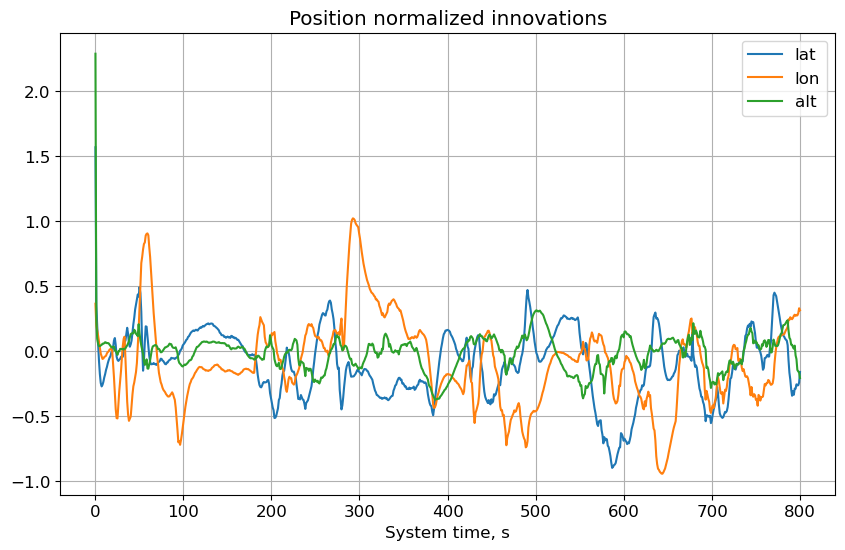

In [9]:
plt.plot(result.innovations['Position'], label=['lat', 'lon', 'alt'])
plt.xlabel("System time, s")
plt.title("Position normalized innovations")
plt.legend()

Here we see that the innovations do not exceed 1 (which is good), but don't look at all like a white sequence (which expected if Kalman filter assumptions are satisfied).

This is unfortunately a typical situation for loosely-coupled INS/GNSS integration. GNSS position is computed by complicated algorithms (typically involving Kalman filtering) and its errors are time correlated in an unpredictable manner. 

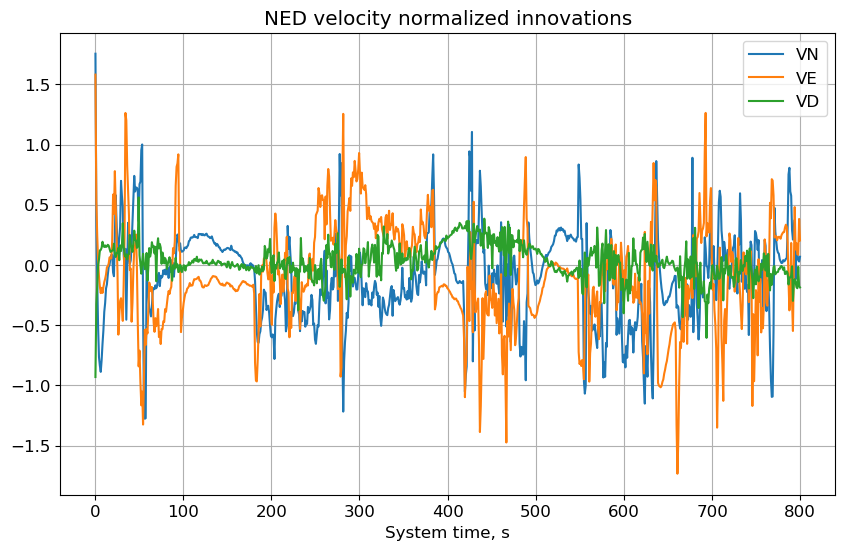

In [10]:
plt.plot(result.innovations['NedVelocity'], label=['VN', 'VE', 'VD'])
plt.xlabel("System time, s")
plt.title("NED velocity normalized innovations")
plt.legend()

Almost the same can be said about the velocity innovations. Typically GNSS velocity errors behave more like an uncorrelated sequence, but they are more succesptible to algorithmic delays due to the filtering process. Here it is also likely that we observe some pyins filter non-optimalities.

All in all the innovation picture doesn't look terrible for a simplistic pyins filter and external GNSS data.

Now let's compute and plot errors (relative to the reference trajectory) and 3-sigma bounds using the filter's standard deviation.

In [11]:
trajectory_error = pyins.transform.compute_state_difference(result.trajectory, reference_trajectory)

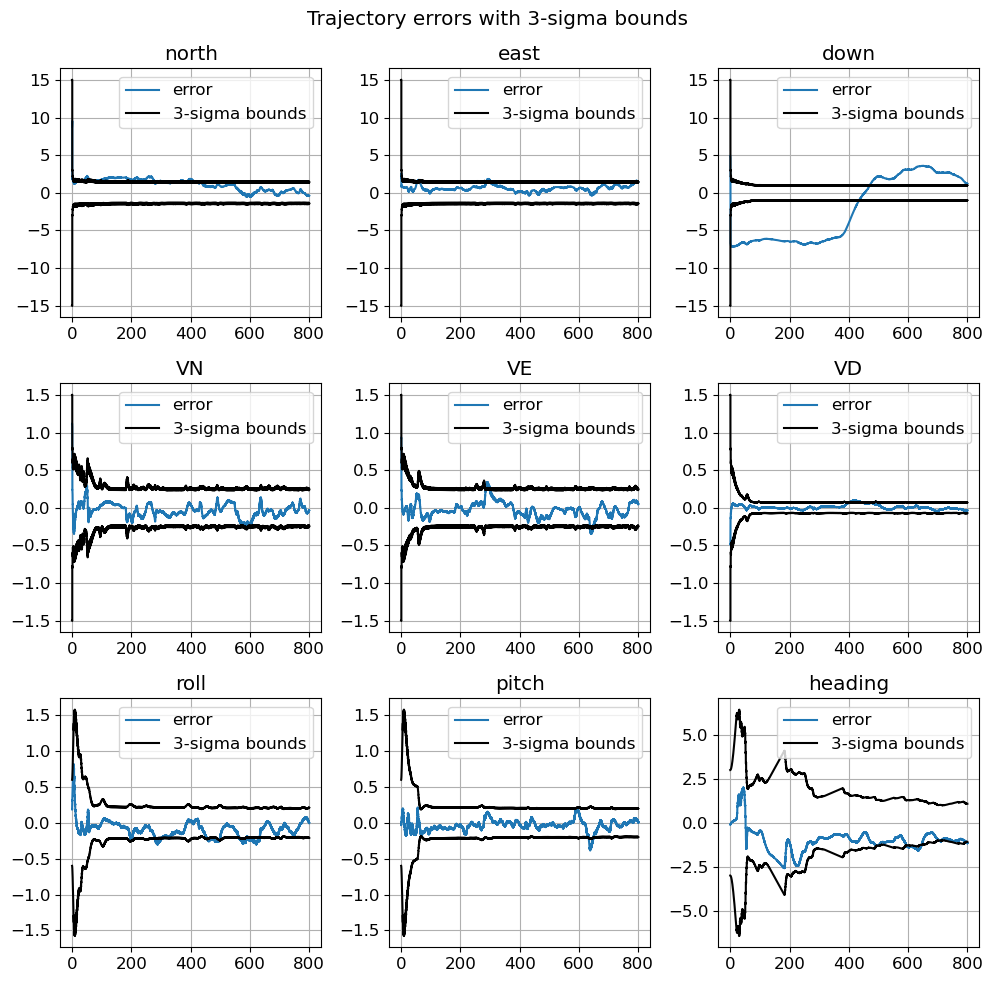

In [12]:
plt.figure(figsize=(10, 10))
for i, col in enumerate(trajectory_error.columns, start=1):
    plt.subplot(3, 3, i)
    plt.plot(trajectory_error[col], label='error')
    plt.plot(3 * result.trajectory_sd[col], 'k', label='3-sigma bounds')
    plt.plot(-3 * result.trajectory_sd[col], 'k')
    plt.legend()
    plt.title(col)

plt.suptitle("Trajectory errors with 3-sigma bounds")
plt.tight_layout()

The position errors are not of high interest here, because the position solutions are essentially computed for different frames of reference due to GNSS position biases (reference RTK position can also be shifted from the true frame due to the base station coordinates offset). It is especially aparent here for the altitude (down) error.

Not much can be said about velocity errors, they are adequate.

The attitude angle errors don't look particularly great - they touch 3-sigma bounds and there are mean offset for roll and pitch angles. But in general they are adequate for simplistic loosly-coupled INS/GNSS and fit in 3-sigma bounds.

Let's also plot gyro and accelerometer parameters estimated to check that the initial bias standard deviation is adequate.

Text(0.5, 0, 'System time, s')

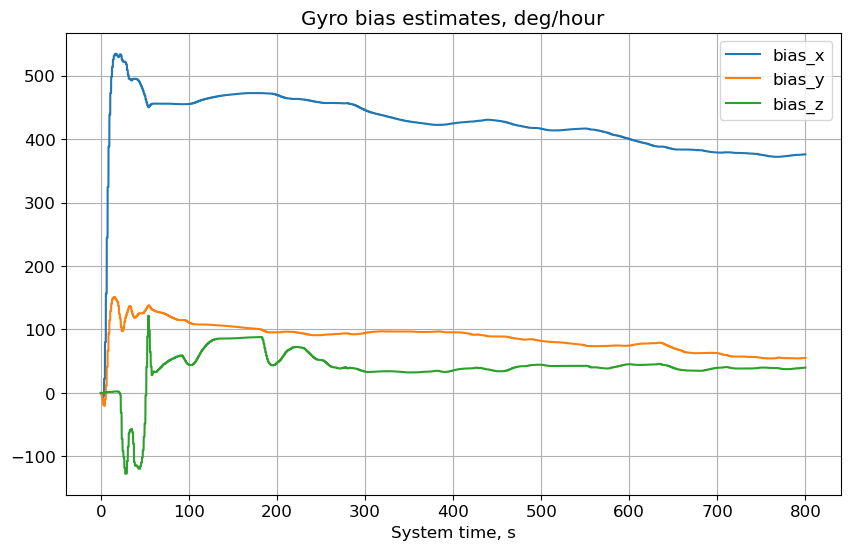

In [13]:
plt.plot(result.gyro * pyins.transform.RS_TO_DH, label=['bias_x', 'bias_y', 'bias_z'])
plt.legend()
plt.title("Gyro bias estimates, deg/hour")
plt.xlabel("System time, s")

Text(0.5, 0, 'System time, s')

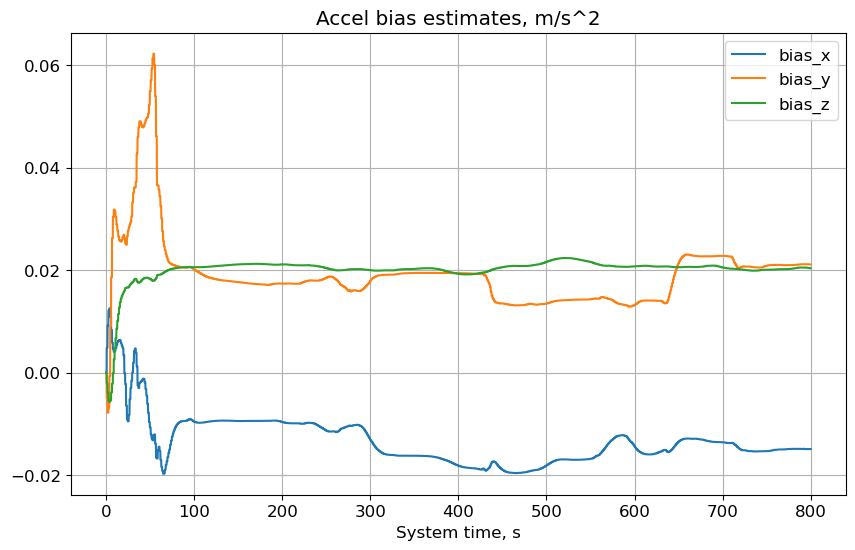

In [14]:
plt.plot(result.accel, label=['bias_x', 'bias_y', 'bias_z'])
plt.legend()
plt.title("Accel bias estimates, m/s^2")
plt.xlabel("System time, s")

Everything looks reasonable. There are some spurious estimate changes, most likely due to problematic statistical properties of GNSS position and velocity data.